In [11]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
from collections import OrderedDict
sns.set()

from tools import *

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
# Algorithms
from minisom import MiniSom

DATA_DIR = Path('../../data')
PROC_DIR = Path(DATA_DIR / 'original/processed')
OUT_DIR = Path('./out/som')

if not OUT_DIR.exists():
    Path.mkdir(OUT_DIR)

flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']

# Helper Functions

In [12]:
def plot_som_results(som_x, som_y, win_map, save_path=None):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0), c="red", linewidth=0.5)
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")
    plt.tight_layout()
    
    if save_path != None:
        plt.savefig(save_path, dpi=200)
        
    plt.show()
    
def plot_unscaled_clusters(labels, nclusters, flows_dict, columns, save_path=None):
    """Plot cluster of the original data (not scaled)"""  
    
    fig, axs = plt.subplots(nrows=nclusters, ncols=len(columns), figsize=(5*len(columns), 4*(nclusters)))
    
    print(axs.shape)
    
    for cluster_id, cluster in labels.items():
        for filename in cluster:
            for col_pos, col in enumerate(columns):
                ax = axs[(cluster_id-1, col_pos)]
                ax.plot(flows_dict[filename][col], linewidth=0.5)
                ax.set(ylabel=col, title=f'Cluster {cluster_id}')
                
    plt.tight_layout()
    
    if save_path != None:
        plt.savefig(save_path, dpi=200)
    
    plt.show()
      


# Load data

In [13]:
filenames = [f for f in PROC_DIR.iterdir()]

flows_dict = OrderedDict()
for f in filenames:
    flows_dict[f.stem] = pd.read_csv(f, skiprows=2, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]'])    

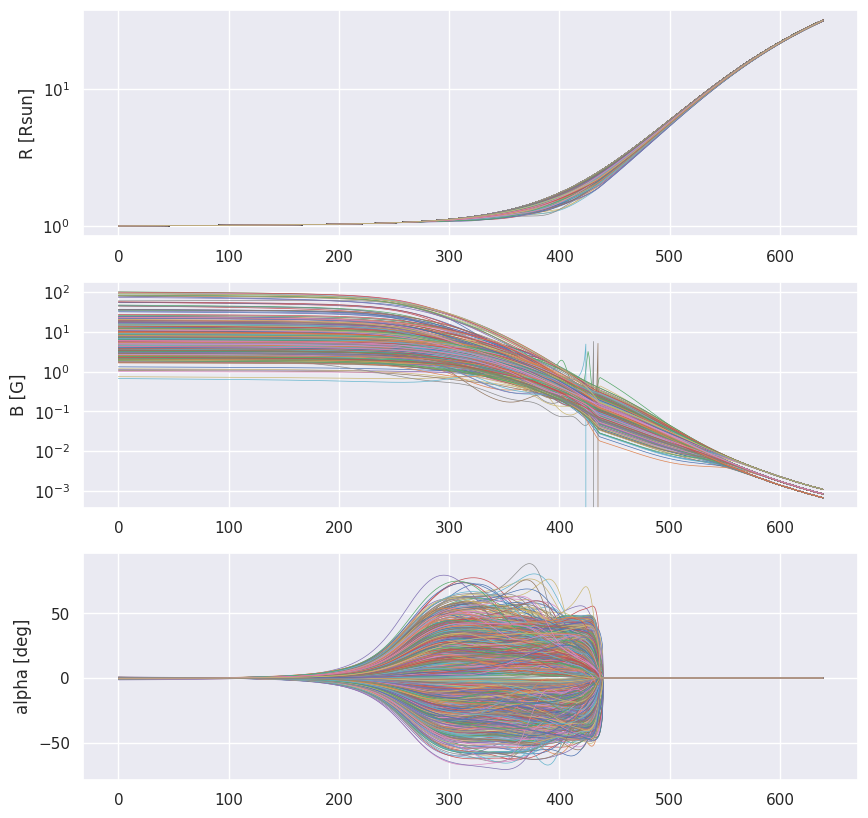

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for idx, col in enumerate(flow_columns):
    for series in flows_dict.values():
        axs[idx].plot(series.index, series[col], linewidth=0.5)
        
axs[0].set_ylabel('R [Rsun]')
axs[1].set_ylabel('B [G]')
axs[2].set_ylabel('alpha [deg]')

axs[0].set_yscale('log')
axs[1].set_yscale('log')
# axs[2].set_yscale('symlog')


## Scale Inputs

In [15]:
scaled_flows = pd.DataFrame()
scaler = QuantileTransformer(n_quantiles=1000, output_distribution='uniform')

for series in flows_dict.values():
    scaled_flows = pd.concat([scaled_flows, series], axis=0)

scaler.fit(scaled_flows)
scaled_flows = scaler.transform(scaled_flows)


scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
print(scaled_flows.shape)
print(scaled_flows.head())
# scaler.fit(scaled_flows)


(754560, 3)
   R [Rsun]     B [G]  alpha [deg]
0  0.000000  0.967434     0.193604
1  0.002002  0.967423     0.193715
2  0.003286  0.967413     0.193828
3  0.005005  0.967402     0.193944
4  0.007007  0.967391     0.194063


# Magnetic Field - B [G]

In [16]:
# separate into file series
scaled_magnetic = [scaled_flows['B [G]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['B [G]']) // 640)]
scaled_magnetic = np.array(scaled_magnetic)
scaled_magnetic[0][:5]


array([0.96743424, 0.96742344, 0.96741261, 0.96740176, 0.96739087])

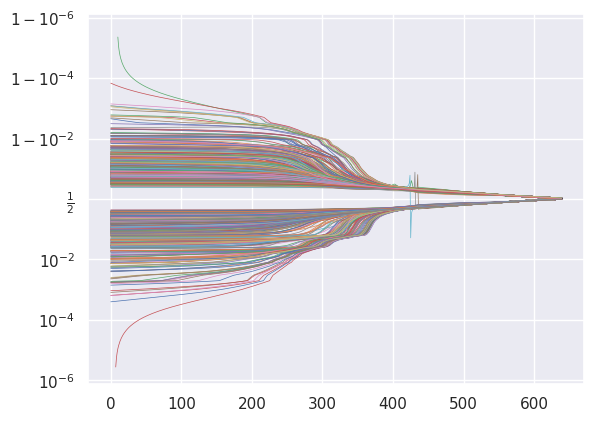

In [17]:
# plot scaled magnetic field
for b_line in scaled_magnetic:
    plt.plot(b_line, linewidth=0.5)

plt.yscale('logit')

## SOM

In [18]:
# rule of thumb number of clusters for SOM is the sqrt of the sqrt of the number of data points
som_x = som_y = 2
som = MiniSom(som_x, som_y, 640, sigma=0.3, learning_rate = 0.1)

train_x = list(scaled_magnetic)

som.random_weights_init(train_x)
som.train(train_x, 50000, verbose=True)

 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.7324369321455514


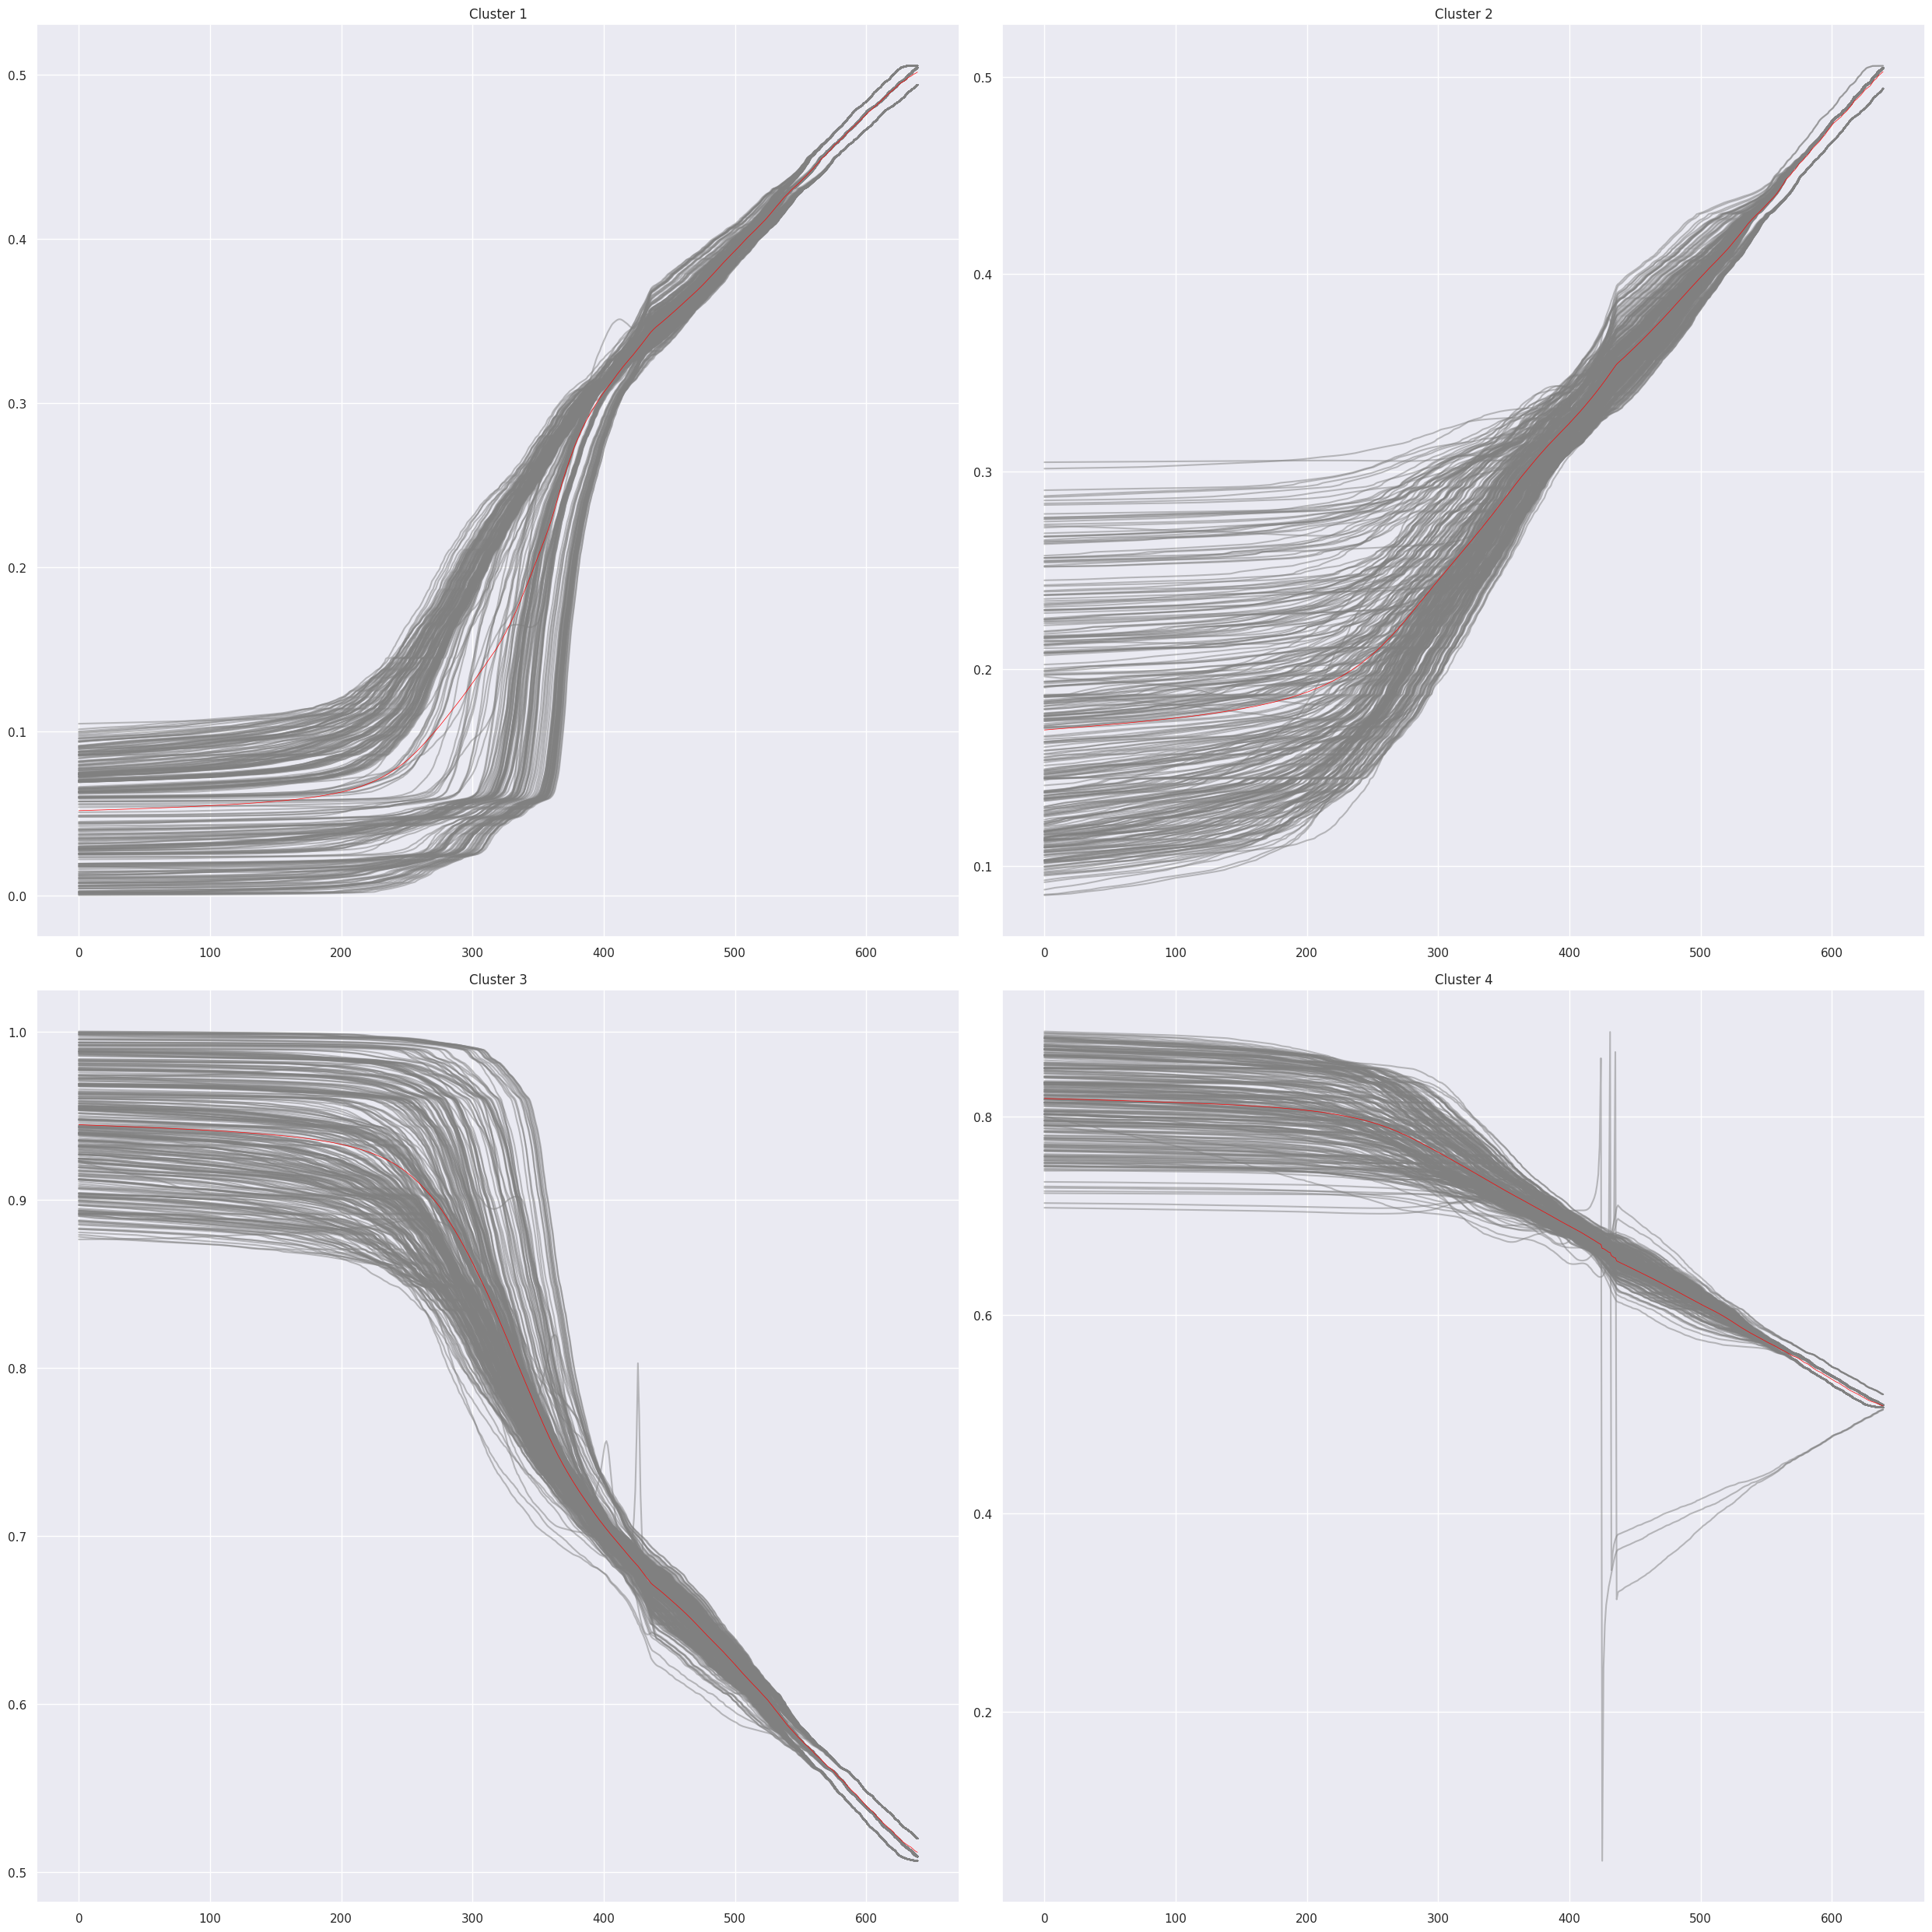

In [19]:
win_map = som.win_map(train_x)
plot_som_results(som_x, som_y, win_map)

### Original data clusters

(4, 2)


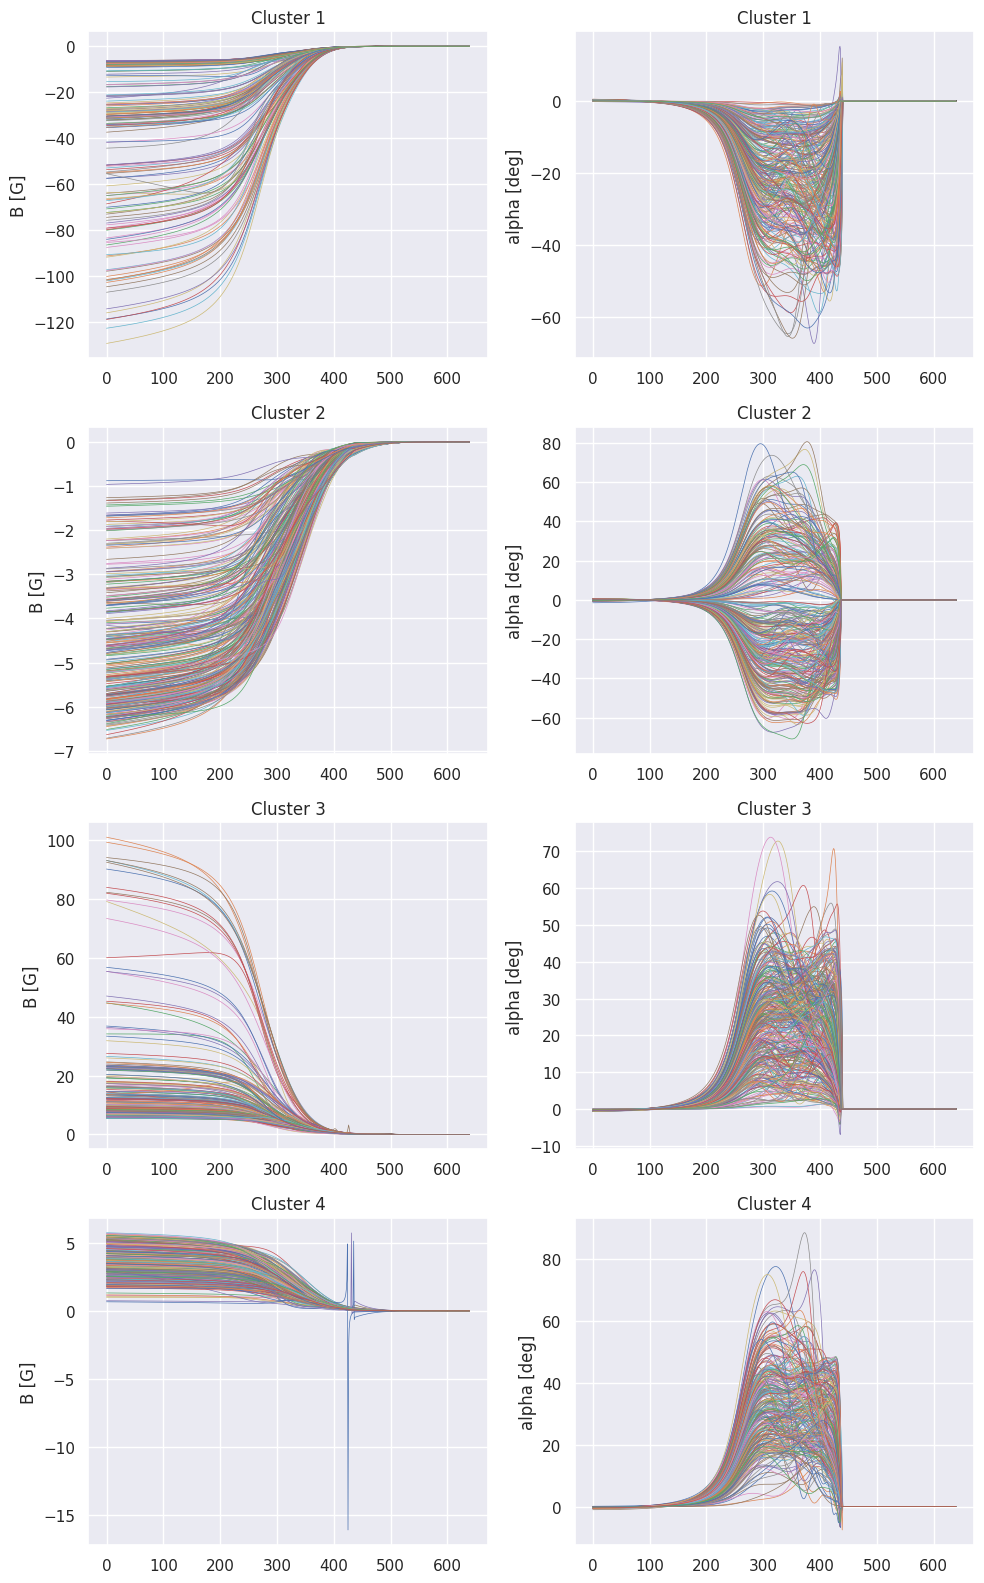

In [20]:
# display unscaled data into clusters
filenames = list(flows_dict.keys())

magnetic_clusters = OrderedDict()
for idx, scaled in enumerate(scaled_magnetic):
    winner_node = som.winner(scaled)
    magnetic_clusters.setdefault(winner_node[0]*som_y + winner_node[1] + 1, list()).append(filenames[idx])

nclusters = max(magnetic_clusters.keys())
plot_unscaled_clusters(magnetic_clusters, nclusters, flows_dict, flow_columns[1:])


### Cluster Distributions

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

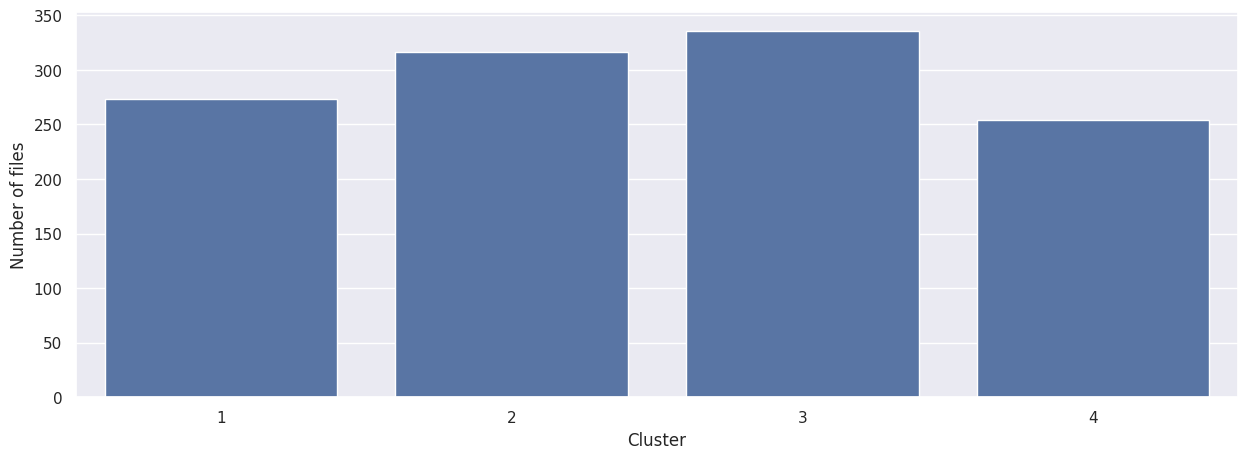

In [21]:
fig, ax = plt.subplots(figsize=(15, 5))
bp = sns.barplot(x=list(magnetic_clusters.keys()), y=[len(v) for v in magnetic_clusters.values()], ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

### Grid Search

In [22]:
%%capture
subdir = OUT_DIR / 'mag'
if not subdir.exists():
    subdir.mkdir()
    
train_x = list(scaled_magnetic)
for i in range(2, math.ceil(math.sqrt(math.sqrt(len(scaled_magnetic))))+1):
    som_x = som_y = i
    som = MiniSom(som_x, som_y, 640, sigma=0.3, learning_rate = 0.1)
    som.random_weights_init(train_x)
    som.train(train_x, 50000, verbose=True)
    
    win_map = som.win_map(train_x)
    plot_som_results(som_x, som_y, win_map, save_path=subdir / f'scaled_{i**2}.png')
    
    # display unscaled data into clusters
    filenames = list(flows_dict.keys())

    mag_clusters = OrderedDict()
    for idx, scaled in enumerate(scaled_magnetic):
        winner_node = som.winner(scaled)
        mag_clusters.setdefault(winner_node[0]*som_y + winner_node[1] + 1, list()).append(filenames[idx])
    
    nclusters = max(mag_clusters.keys())
    plot_unscaled_clusters(mag_clusters, nclusters, flows_dict,
                        flow_columns[1:], save_path=subdir / f'unscaled{i**2}.png')
        

 [ 50000 / 50000 ] 100% - 0:00:00 left 

# Flux Tube Inclination - alpha [deg]

In [23]:
# separate into file series
scaled_alpha = [scaled_flows['alpha [deg]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['alpha [deg]']) // 640)]
scaled_alpha = np.array(scaled_alpha)
scaled_alpha[0][:5]


array([0.19360392, 0.19371457, 0.19382795, 0.19394409, 0.19406302])

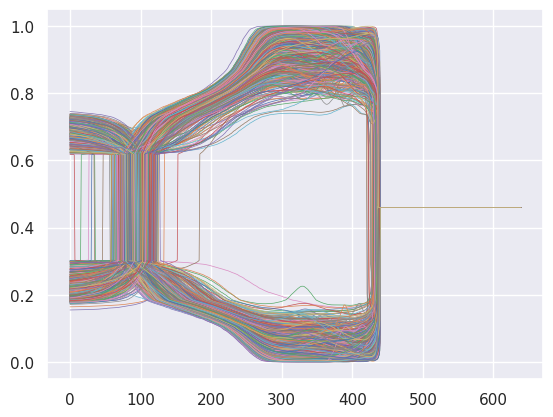

In [24]:
# plot scaled magnetic field
for a_line in scaled_alpha:
    plt.plot(a_line, linewidth=0.5)

plt.yscale('linear')

## SOM

In [28]:
# rule of thumb number of clusters for SOM is the sqrt of the sqrt of the number of data points
som_x = som_y = 2
som = MiniSom(som_x, som_y, 640, sigma=0.3, learning_rate = 0.1)

train_x = list(scaled_alpha)

som.random_weights_init(train_x)
som.train(train_x, 50000, verbose=True)

 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 1.115625537544797


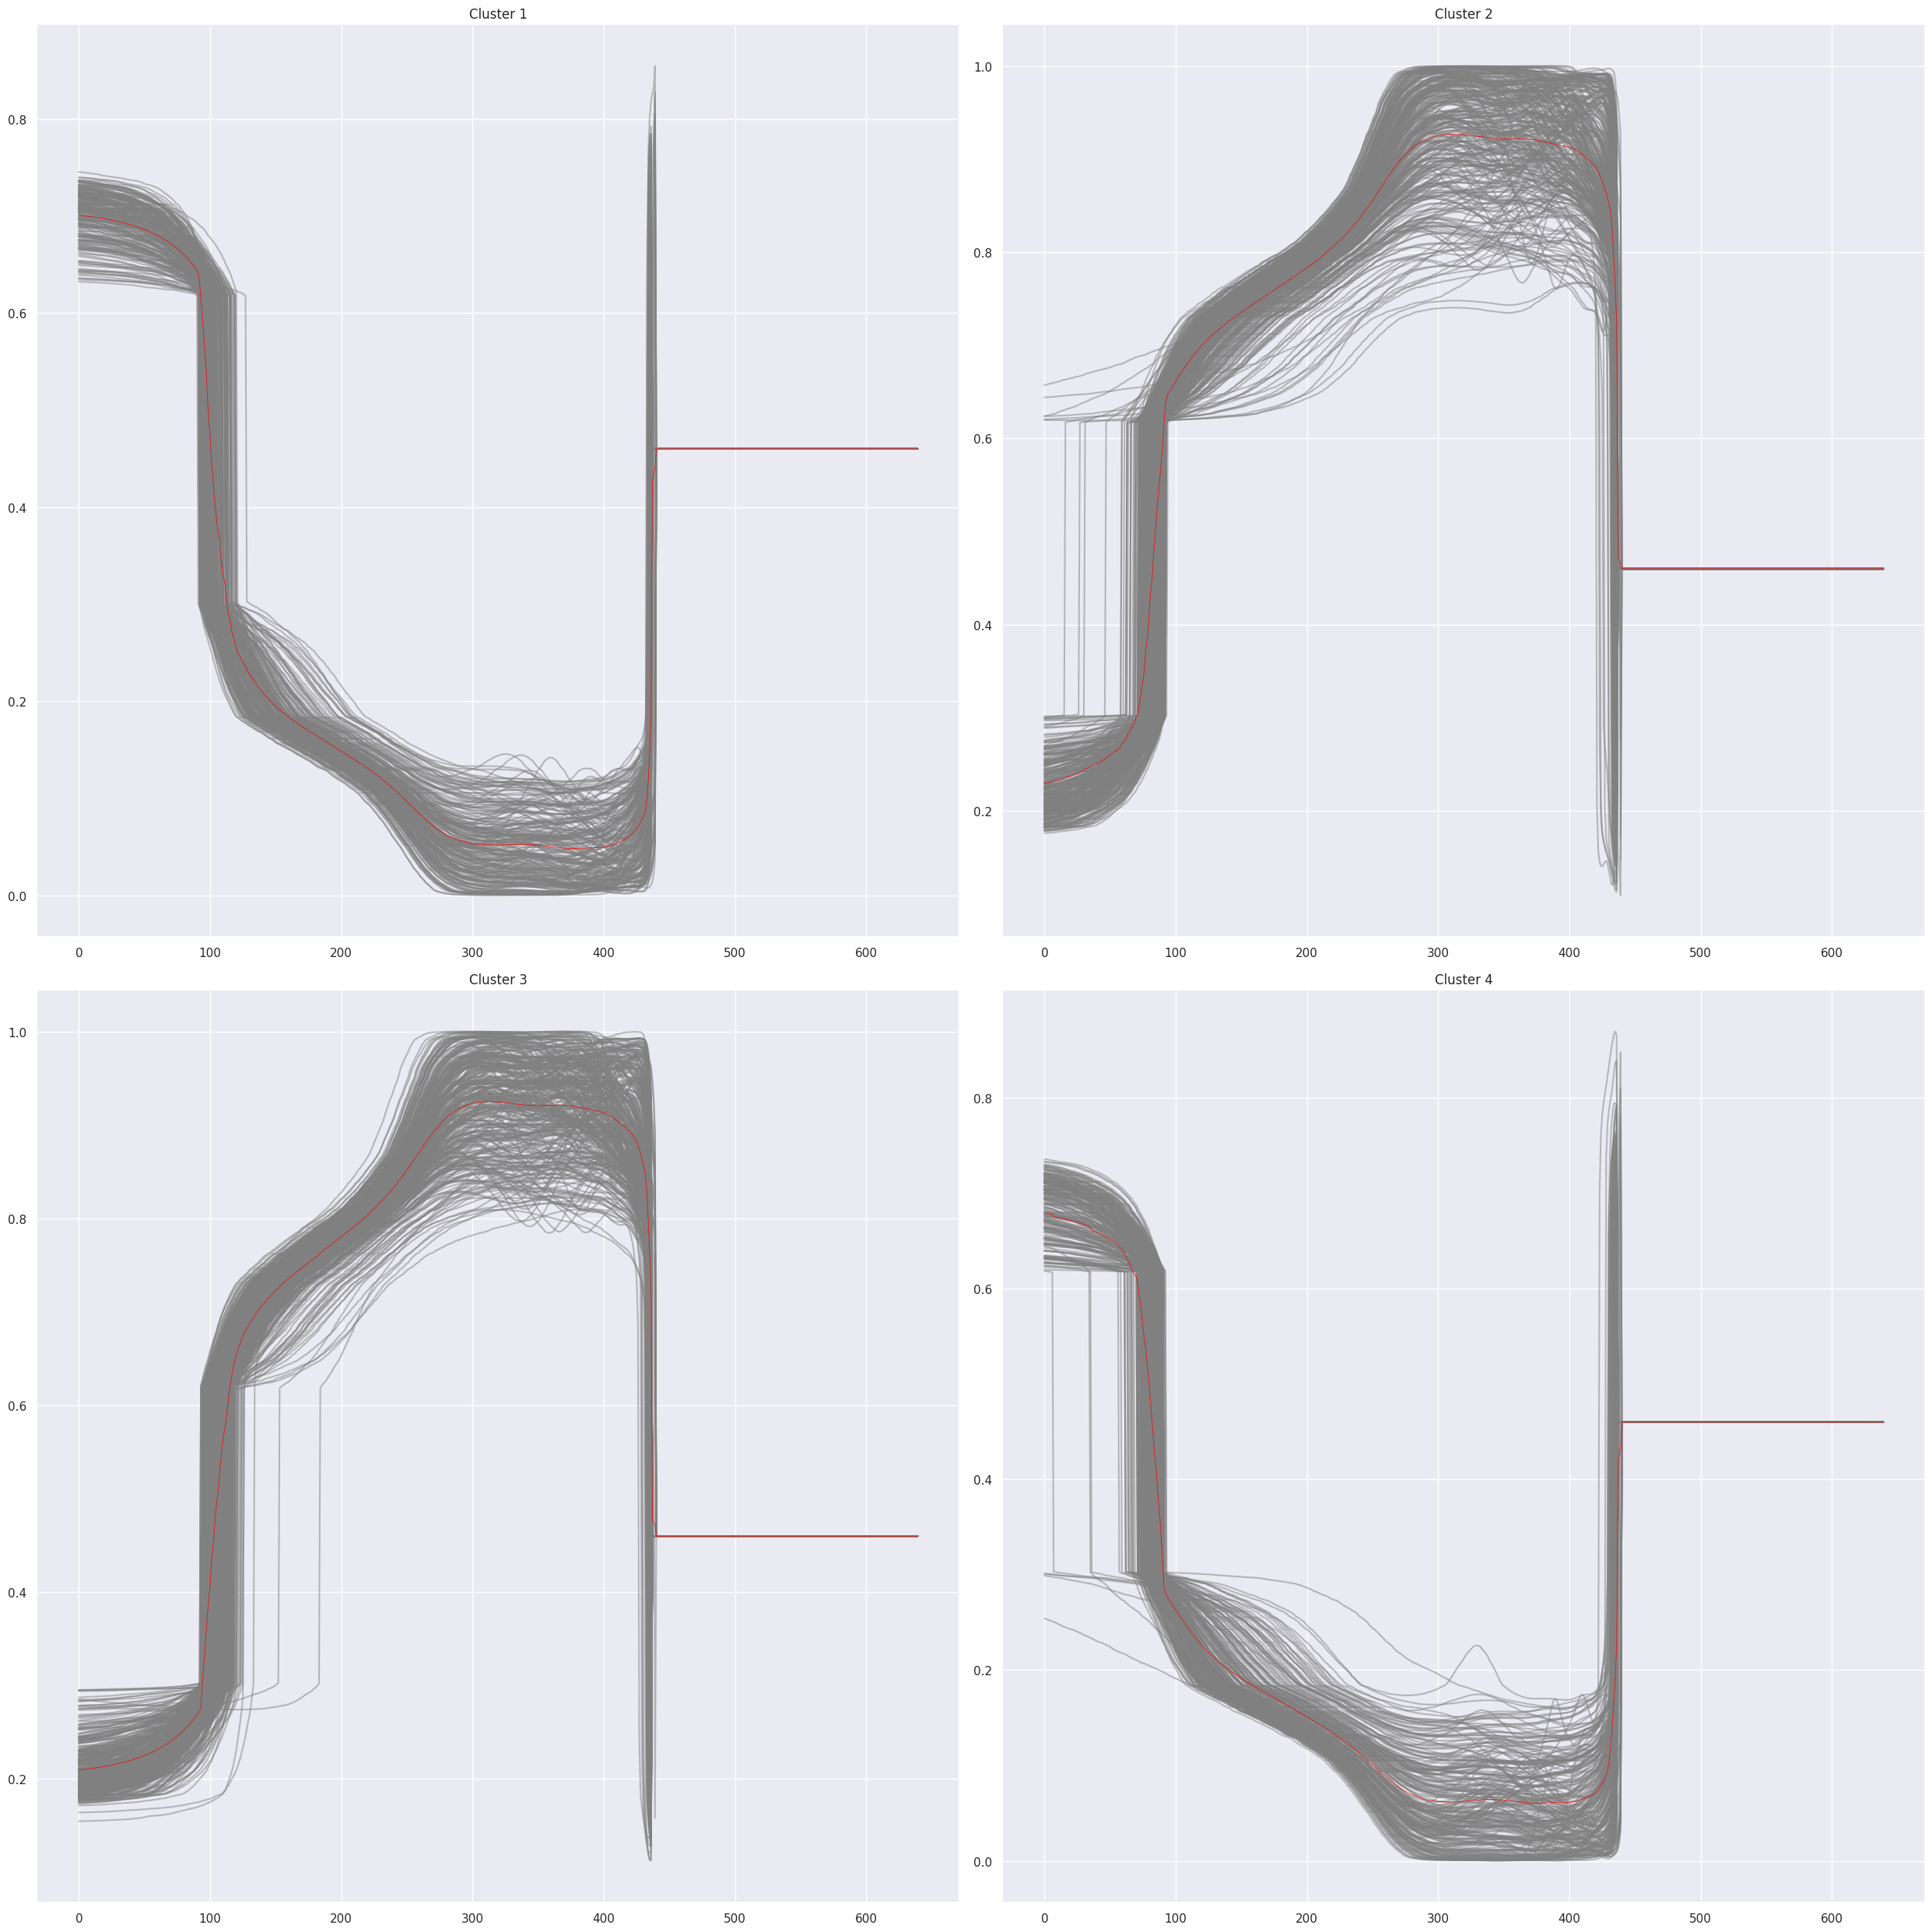

In [29]:
win_map = som.win_map(train_x)
plot_som_results(som_x, som_y, win_map)

### Original Data Clusters

(4, 2)


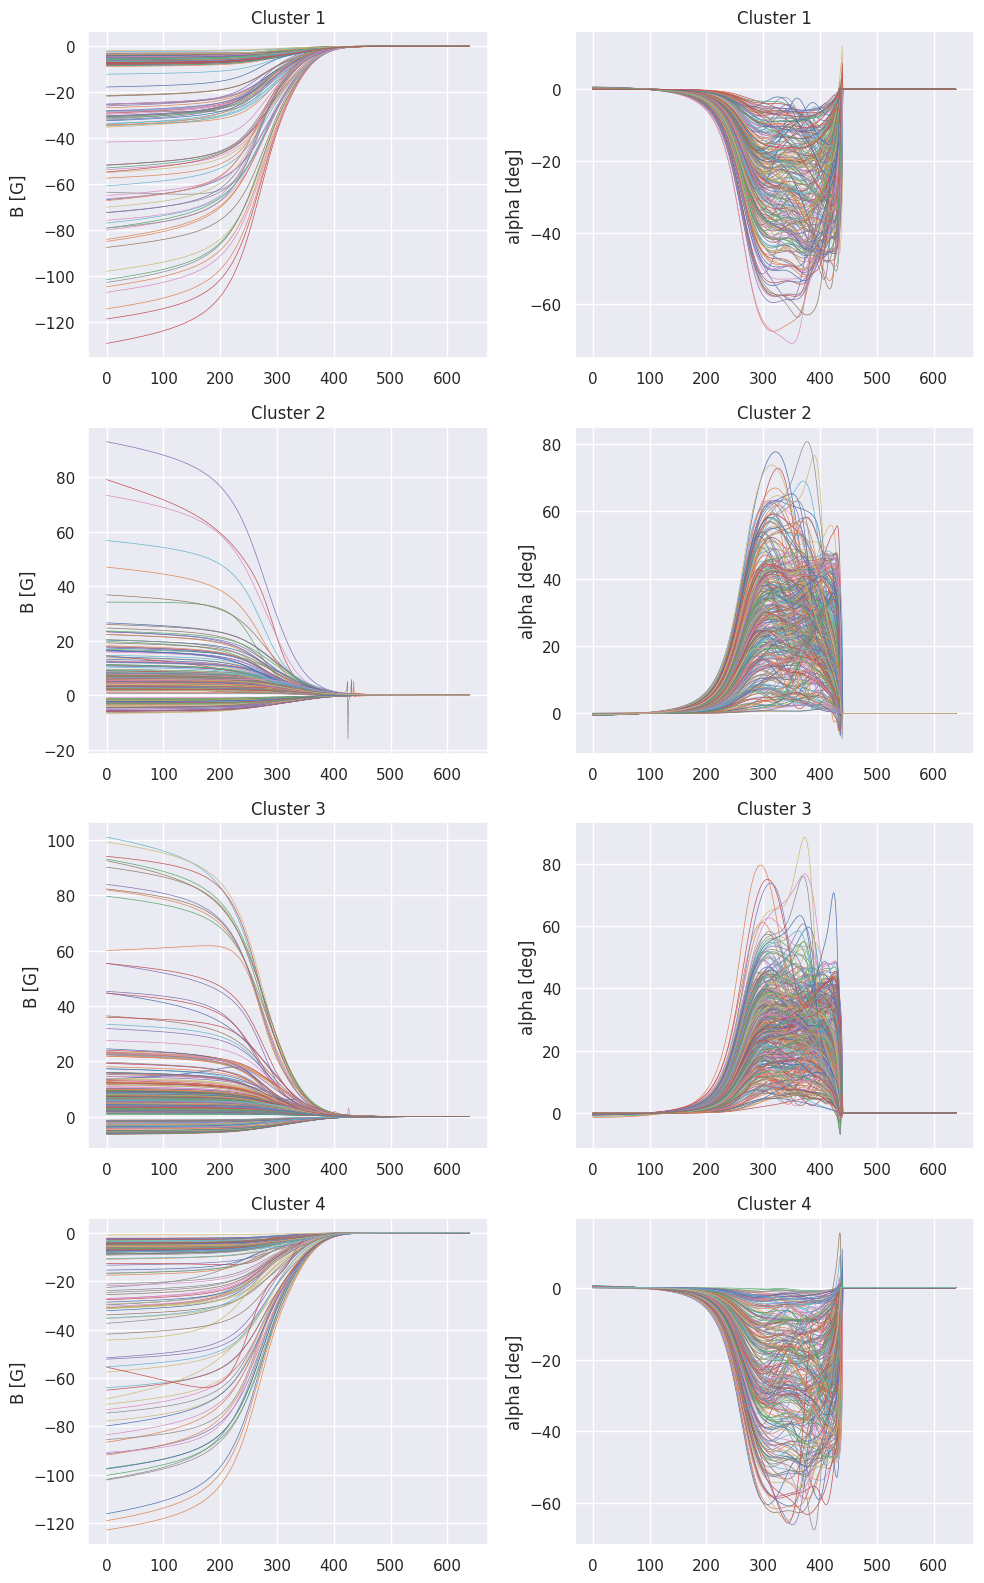

In [30]:
# display unscaled data into clusters
filenames = list(flows_dict.keys())

alpha_clusters = OrderedDict()
for idx, scaled in enumerate(scaled_alpha):
    winner_node = som.winner(scaled)
    alpha_clusters.setdefault(winner_node[0]*som_y + winner_node[1] + 1, list()).append(filenames[idx])

nclusters = max(alpha_clusters.keys())
plot_unscaled_clusters(alpha_clusters, nclusters, flows_dict, flow_columns[1:])

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

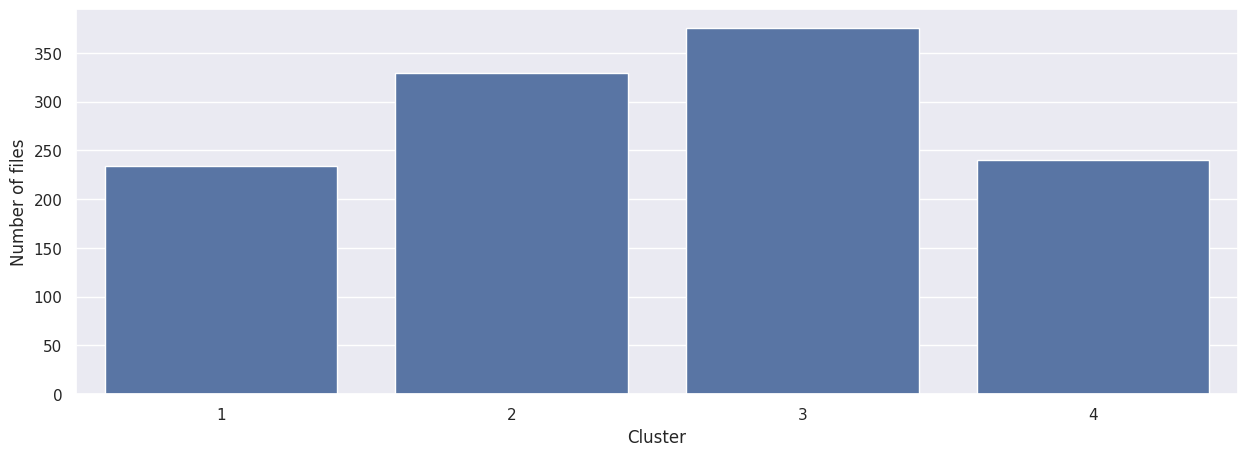

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
bp = sns.barplot(x=list(alpha_clusters.keys()), y=[len(v) for v in alpha_clusters.values()], ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

### Grid Search

In [32]:
%%capture
subdir = OUT_DIR / 'alpha'
if not subdir.exists():
    subdir.mkdir()
    
train_x = list(scaled_alpha)
for i in range(2, math.ceil(math.sqrt(math.sqrt(len(scaled_alpha))))+1):
    som_x = som_y = i
    som = MiniSom(som_x, som_y, 640, sigma=0.3, learning_rate = 0.1)
    som.random_weights_init(train_x)
    som.train(train_x, 50000, verbose=True)
    
        
    win_map = som.win_map(train_x)
    plot_som_results(som_x, som_y, win_map, save_path=subdir / f'scaled_{i**2}.png')
    
    # display unscaled data into clusters
    filenames = list(flows_dict.keys())

    alpha_clusters = OrderedDict()
    for idx, scaled in enumerate(scaled_alpha):
        winner_node = som.winner(scaled)
        alpha_clusters.setdefault(winner_node[0]*som_y + winner_node[1] + 1, list()).append(filenames[idx])
    
    nclusters = max(alpha_clusters.keys())
    plot_unscaled_clusters(alpha_clusters, nclusters, flows_dict,
                        flow_columns[1:], save_path=subdir / f'unscaled_{i**2}.png')
        

 [ 50000 / 50000 ] 100% - 0:00:00 left 